In [27]:
import pandas as pd, numpy as np, warnings, re
import matplotlib.pyplot as plt, matplotlib, plotly.graph_objs as go, plotly.express as px, seaborn as sns
warnings.filterwarnings(action = 'ignore')
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'AppleGothic')

from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.preprocessing import *

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


In [28]:
## 데이터 로드

data = pd.read_csv('Interest_rate_prediction.csv')
df = data.copy()

df

,DATE,DFEDTARU,DFEDTARL,IR_FORCAST,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_text,BB_neg,BB_neu,BB_pos,BB_sentiment,DATE_YM
0,2009-01-01,0.25,0.00,0.50,-4.5,7.8,88.108,2.244,1259.5,3.0,2.50,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2008-12
1,2009-02-01,0.25,0.00,0.25,-4.5,8.3,88.266,2.844,1379.5,2.5,2.00,Prepared at the Federal Reserve Bank of St. Lo...,0.061,0.865,0.074,0.9952,2009-01
2,2009-03-01,0.25,0.00,0.25,-4.5,8.7,88.169,3.041,1534.0,2.0,2.00,Prepared at the Federal Reserve Bank of San Fr...,0.083,0.839,0.078,0.5459,2009-02
3,2009-04-01,0.25,0.00,0.25,-0.7,9.0,88.295,2.658,1379.5,2.0,1.50,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-03
4,2009-05-01,0.25,0.00,0.25,-0.7,9.4,88.387,3.174,1282.0,2.0,1.25,Prepared at the Federal Reserve Bank of Dallas...,0.092,0.826,0.082,-0.6999,2009-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2024-03-01,5.50,5.25,5.50,1.4,3.8,122.782,4.180,1331.5,3.5,4.50,National Summary Overall Economic Activity Eco...,0.056,0.797,0.147,0.9991,2024-02
183,2024-04-01,5.50,5.25,5.50,2.8,3.9,123.106,4.329,1349.4,3.5,4.50,National Summary Overall Economic Activity Ove...,0.068,0.807,0.126,0.9974,2024-03
184,2024-05-01,5.50,5.25,5.50,2.8,4.0,123.096,4.595,1382.0,3.5,4.50,National Summary Overall Economic Activity Nat...,0.076,0.783,0.141,0.9982,2024-04
185,2024-06-01,5.50,5.25,5.50,2.8,4.1,123.096,4.514,1384.5,3.5,4.50,National Summary Overall Economic Activity Nat...,0.076,0.783,0.141,0.9982,2024-05


In [29]:
## 추가 전처리: BB_text 텍스트 데이터 전 처리 및 sentiment 재계산

# BB_text 텍스트 데이터 전 처리
# 소문자 통일, 공백 제거
df['BB_text'] = df['BB_text'].str.lower()  # 소문자로
df['BB_text'] = df['BB_text'].str.strip()  # 앞뒤 공백 제거
df['BB_text'] = df['BB_text'].str.replace('\s+', ' ', regex=True)  # 중간 공백 제거
df['BB_text'] = df['BB_text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))

# 불용어 제거
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])
df['BB_text'] = df['BB_text'].apply(remove_stopwords)


# sentiment 재계산
# 감성분석
sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['neg'], sentiment['neu'], sentiment['pos'], sentiment['compound']

df[['BB_neg', 'BB_neu', 'BB_pos', 'BB_sentiment']] = df['BB_text'].apply(lambda text: pd.Series(get_vader_sentiment(text)))

In [30]:
# target: 상한 기준금리 # EDA와는 다른 점: 상관계수가 높은 IR_FORCAST 삭제
df['TARGET'] = df['DFEDTARU']
del df['IR_FORCAST'], df['DFEDTARL'],df['DFEDTARU'], df['BB_text'], df['BB_neg'], df['BB_neu'], df['BB_pos'], df['DATE_YM']
df['DATE'] = pd.to_datetime(df['DATE'])

df.set_index('DATE', inplace=True)
df

,GDPGR,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,BB_sentiment,TARGET
DATE,,,,,,,,,
2009-01-01,-4.5,7.8,88.108,2.244,1259.5,3.0,2.50,0.9672,0.25
2009-02-01,-4.5,8.3,88.266,2.844,1379.5,2.5,2.00,0.9672,0.25
2009-03-01,-4.5,8.7,88.169,3.041,1534.0,2.0,2.00,-0.0337,0.25
2009-04-01,-0.7,9.0,88.295,2.658,1379.5,2.0,1.50,-0.8687,0.25
2009-05-01,-0.7,9.4,88.387,3.174,1282.0,2.0,1.25,-0.8687,0.25
...,...,...,...,...,...,...,...,...,...
2024-03-01,1.4,3.8,122.782,4.180,1331.5,3.5,4.50,0.9977,5.50
2024-04-01,2.8,3.9,123.106,4.329,1349.4,3.5,4.50,0.9952,5.50
2024-05-01,2.8,4.0,123.096,4.595,1382.0,3.5,4.50,0.9974,5.50


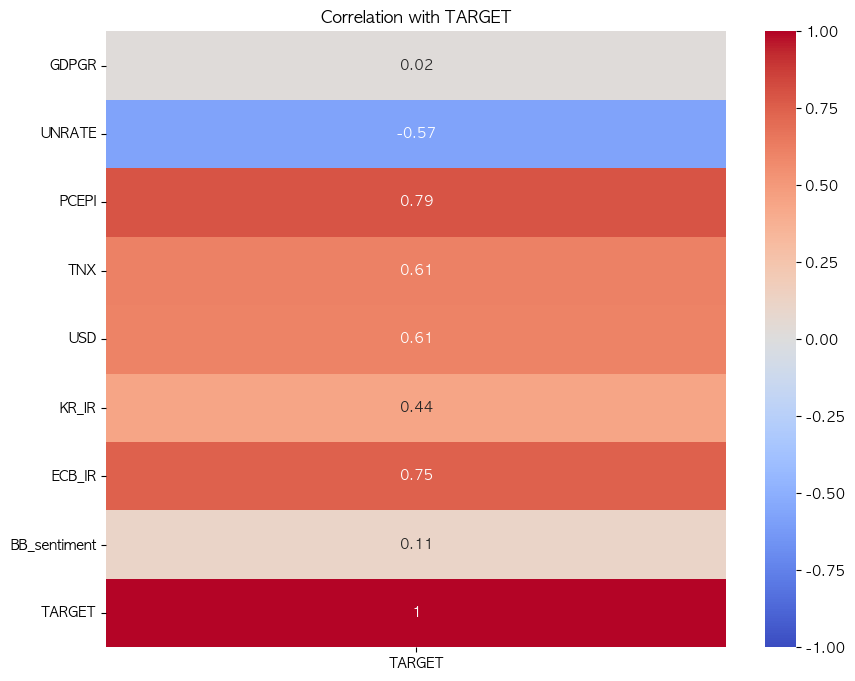

In [31]:
# 데이터프레임에서 상관 행렬 계산
correlation_matrix = df.corr()

# TARGET과 다른 변수 간의 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['TARGET']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with TARGET')
plt.show()


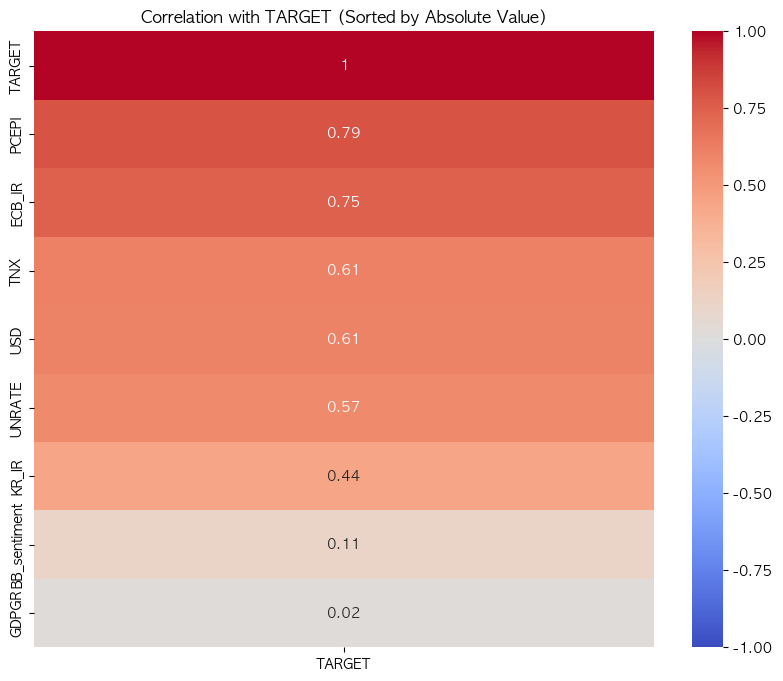

                TARGET
TARGET        1.000000
PCEPI         0.790504
ECB_IR        0.745583
TNX           0.613604
USD           0.607943
UNRATE        0.573235
KR_IR         0.444098
BB_sentiment  0.111887
GDPGR         0.020344


In [32]:
# 상관계수 절댓값 기준 내림차순
# 상관 행렬 계산
correlation_matrix = df.corr()

# TARGET과의 상관계수 가져오기
target_corr = correlation_matrix[['TARGET']]

# 상관계수를 절댓값 기준으로 정렬
sorted_target_corr = target_corr.abs().sort_values(by='TARGET', ascending=False)

# 정렬된 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_target_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation with TARGET (Sorted by Absolute Value)')
plt.show()

# 정렬된 상관계수 출력
print(sorted_target_corr)

In [33]:
## 데이터 추가 전처리: 상관계수가 낮은 변수 BB_sentiment, GDPGR 삭제
del df['BB_sentiment'], df['GDPGR']

df

,UNRATE,PCEPI,TNX,USD,KR_IR,ECB_IR,TARGET
DATE,,,,,,,
2009-01-01,7.8,88.108,2.244,1259.5,3.0,2.50,0.25
2009-02-01,8.3,88.266,2.844,1379.5,2.5,2.00,0.25
2009-03-01,8.7,88.169,3.041,1534.0,2.0,2.00,0.25
2009-04-01,9.0,88.295,2.658,1379.5,2.0,1.50,0.25
2009-05-01,9.4,88.387,3.174,1282.0,2.0,1.25,0.25
...,...,...,...,...,...,...,...
2024-03-01,3.8,122.782,4.180,1331.5,3.5,4.50,5.50
2024-04-01,3.9,123.106,4.329,1349.4,3.5,4.50,5.50
2024-05-01,4.0,123.096,4.595,1382.0,3.5,4.50,5.50


In [34]:
# 1. 데이터 전처리
# 독립 변수와 타겟 변수 분리
features = df.drop(columns='TARGET')
target = df['TARGET']

# 데이터 정규화
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_features = scaler_features.fit_transform(df.drop('TARGET', axis=1))
scaled_target = scaler_target.fit_transform(df[['TARGET']])

In [35]:
# 모델 훈련
model = LinearRegression()
model.fit(scaled_features, target)

# 회귀 계수
importance = model.coef_
feature_importance = pd.DataFrame(importance, index=features.columns, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

        Importance
ECB_IR    2.724308
PCEPI     1.814672
TNX       1.250981
USD       0.155659
KR_IR    -0.048393
UNRATE   -2.436967


# LSTM

In [42]:
# 2. 모델 정의
# 데이터 분리
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_features, scaled_target, 10)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, shuffle=False, random_state=42)

model = Sequential()
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

# 콜백 정의
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_acc', save_best_only=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])



Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - acc: 0.7001 - loss: 0.0086 - val_acc: 0.3380 - val_loss: 0.2250
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - acc: 0.6761 - loss: 0.0088 - val_acc: 0.3380 - val_loss: 0.2235
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.7063 - loss: 0.0065 - val_acc: 0.3380 - val_loss: 0.2263
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - acc: 0.6886 - loss: 0.0046 - val_acc: 0.3380 - val_loss: 0.1998
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - acc: 0.6834 - loss: 0.0030 - val_acc: 0.3380 - val_loss: 0.1645
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.6761 - loss: 0.0041 - val_acc: 0.3380 - val_loss: 0.1728
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - acc: 0.6678 - loss: 0.0029 - val_acc: 0.3380 - val_loss: 0.1916
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.7136 - loss: 0.0021 - val_acc: 0.3380 - val_loss: 0.1912
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.6792 - loss:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.7032 - loss: 3.9109e-04 - val_acc: 0.3803 - val_loss: 0.0977
Epoch 55/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.7001 - loss: 3.8422e-04 - val_acc: 0.4366 - val_loss: 0.0886
Epoch 56/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - acc: 0.7261 - loss: 5.4202e-04 - val_acc: 0.4366 - val_loss: 0.0900
Epoch 57/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.7355 - loss: 5.0240e-04 - val_acc: 0.3380 - val_loss: 0.1077
Epoch 58/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.6938 - loss: 5.6298e-04 - val_acc: 0.3803 - val_loss: 0.0995
Epoch 59/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.6740 - loss: 4.0577e-04 - val_acc: 0.4225 - val_loss: 0.0929
Epoch 60/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.7053 - loss: 3.7263e-04 - val_acc: 0.3803 - val_loss: 0.1009
Epoch 61/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - acc: 0.7053 - loss: 4.4402e-04 - val_acc: 0.3944 - val_loss: 0.0966
Epoch 62/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms

In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         1,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,881 (378.45 KB)

 Trainable params: 32,293 (126.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,588 (252.30 KB)

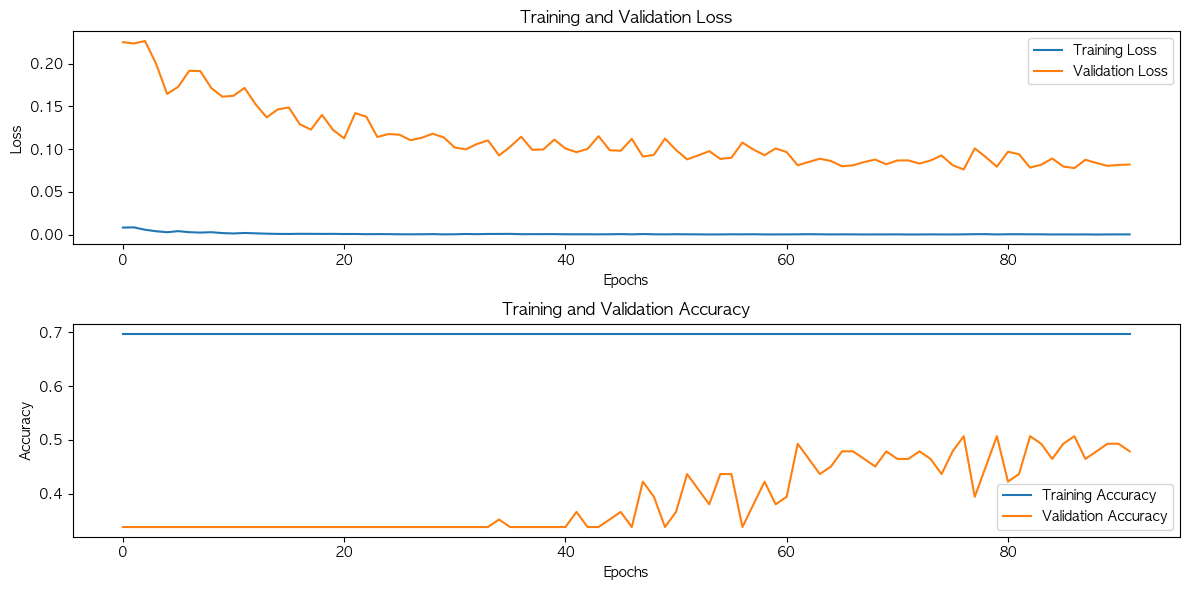

In [44]:
# 학습 손실과 검증 손실 시각화
plt.figure(figsize=(12, 6))

# 손실 그래프
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 그래프
plt.subplot(2, 1, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


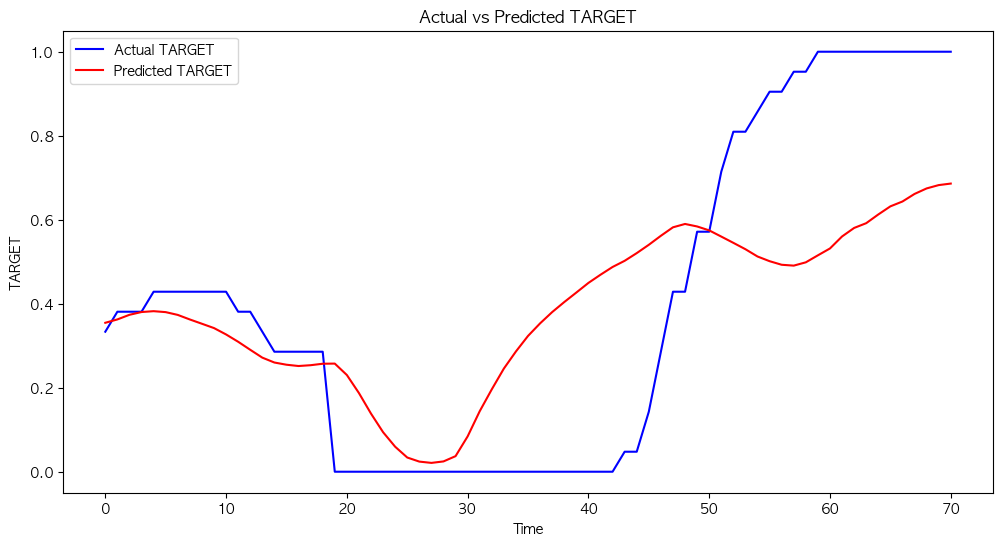

In [45]:
# 검증 데이터에 대한 예측
y_pred = model.predict(X_val)

# 실제 값과 예측 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual TARGET',color='blue')
plt.plot(y_pred, label='Predicted TARGET',color='red')
plt.xlabel('Time')
plt.ylabel('TARGET')
plt.title('Actual vs Predicted TARGET')
plt.legend()
plt.show()


In [46]:
## 복원된 데이터와 예측 값
# 전체 검증 데이터와 예측 값 복원(정규화 해제)
y_val_orig = MinMaxScaler().fit(target.values.reshape(-1, 1)).inverse_transform(y_val)
y_pred_orig = MinMaxScaler().fit(target.values.reshape(-1, 1)).inverse_transform(y_pred)

# 전체 데이터 포인트를 시각화
fig = go.Figure()

# 실제 값 추가
fig.add_trace(go.Scatter(x=df.index[-len(y_val_orig):], y=y_val_orig.flatten(), mode='lines', name='Actual TARGET', line=dict(color='blue')))

# 예측 값 추가
fig.add_trace(go.Scatter(x=df.index[-len(y_pred_orig):], y=y_pred_orig.flatten(), mode='lines', name='Predicted TARGET', line=dict(color='red', dash='dash')))

# 레이아웃 설정
fig.update_layout(title='Actual vs Predicted TARGET',
                  xaxis_title='Date',
                  yaxis_title='TARGET',
                  legend_title='Legend')

# 그래프 보여주기
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


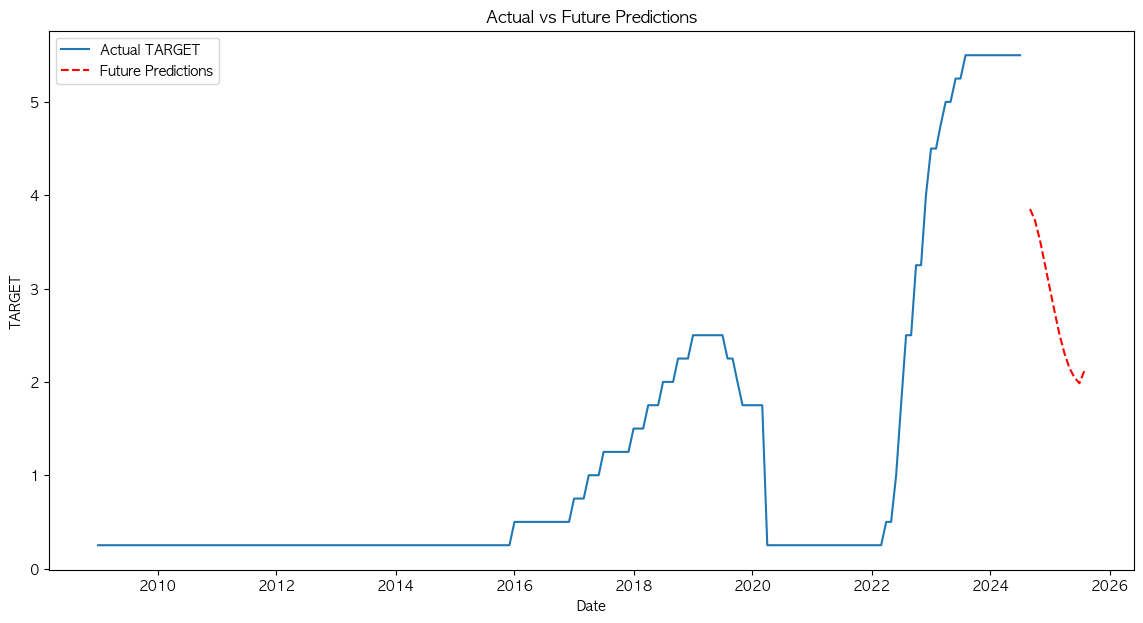

In [47]:
## Target 미래 예측
# 미래 예측을 위한 데이터 준비
def predict_future(model, last_sequence, n_future):
    predictions = []
    sequence = last_sequence

    for _ in range(n_future):
        pred = model.predict(sequence[np.newaxis, :, :])[0, 0]
        predictions.append(pred)
        # 업데이트 sequence
        sequence = np.roll(sequence, shift=-1, axis=0)
        sequence[-1, 0] = pred

    return np.array(predictions)

# 마지막 시퀀스 가져오기
last_sequence = X_val[-1]

# 미래 예측
n_future = 12  # 예측할 미래 기간 (예: 12개월)
future_predictions = predict_future(model, last_sequence, n_future)

# 미래 예측 결과를 원래 스케일로 복원
future_predictions = scaler_target.inverse_transform(future_predictions.reshape(-1, 1))

# 예측 날짜 범위 생성 (closed 매개변수 사용 없이)
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=n_future + 1, freq='M')[1:]

# 예측 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['TARGET'], label='Actual TARGET')
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('TARGET')
plt.title('Actual vs Future Predictions')
plt.legend()
plt.show()